# Convergence speed analysis

This notebook assumes the user is in his own machine.

TODO: still missing CMA-ES analysis and correct CSA graph

**Change this if necessary:**

In [1]:
USER = "st76i1_1"
GROUP = "st76i1"
PASSWORD = input()

In [2]:
import sys
sys.path.append('/home/lucca/propagation-code-optimization') # change this

### Generate runs

In [3]:
# make upload
!sshpass -p {PASSWORD} \
    scp -r ../../optimizer/ {USER}@chome.metz.supelec.fr:/usr/users/{GROUP}/{USER}/


In [4]:
# run algorithm on cluster
runs = [
    #"--algorithm hill_climbing --steps 100",
    #"--algorithm greedy --steps 10",
    #"--algorithm tabu_greedy --steps 10 --hparams '{\"n_tabu\":5}'",
    #"--algorithm simulated_annealing --steps 100 --hparams '{\"t0\":20}'",
    #"--algorithm csa --steps 100",
    "--algorithm cmaes --steps 100",
]

import pexpect

child = pexpect.spawn(f"sshpass -p {PASSWORD} \
                      ssh -tt {USER}@chome.metz.supelec.fr \
                      srun -p cpu_tp -N 1 -n 32 --pty bash",
                      timeout=5*60)

prompt = f"{USER}@kyle[0-9]+:"

for i in range(len(runs)):
    occupied = child.expect([prompt, "srun: job [1-9]+ queued and waiting for resources"])

    if occupied == 0:
        cmd = f"python3 -m optimizer.main {runs[i]} --log convergence_run_{i}.log"
        child.sendline(cmd)
        running = 1
        while running == 1:
            running = child.expect(['Run finished', '\n'])
            output = child.before.decode()
            print(output)
        output = child.after.decode()
        print(output)

    elif occupied == 1:
        raise Exception("Error: no resource available. Try running `mysrun` and `scancel` on the remote machine.")
    
child.close()


 ~st76i1_1@kyle68:~$ python3 -m optimizer.main --algorithm cmaes --steps 100 --log convergence_run_cmaes0.log
MPI startup(): PMI server not found. Please set I_MPI_PMI_LIBRARY variable if it is not a singleton case.
[info] [Me=0] Args:
	algorithm: cmaes
	batch: False
	flexible_shape: False
	hparams: {}
	log: convergence_run_cmaes0.log
	phase: deploy
	problem_size: [256, 256, 256]
	program_path: iso3dfd-st7
	seed: 33
	steps: 100
	use_energy: False
[info] [Me=0] Hyperparameters:
[info] [Me=0] real seed: 33
[info] [Me=0] Executed command: /usr/bin/mpirun -np 1 -map-by ppr:1:node:PE=16 python3 -m optimizer.main --algorithm cmaes --hparams '{}' --log convergence_run_cmaes0.log --phase run --problem_size 256 256 256 --program_path iso3dfd-st7 --seed 33 --steps 100 
Unable to init server: Could not connect: Connection refused
Unable to init server: Impossible de se connecter : Connection refused

(main.py:937861): Gdk-CRITICAL **: 15:46:00.948: gdk_cursor_new_for_display: assertion 'GDK_IS_D

In [5]:
# make get_logs
!mkdir -p tmp/
!sshpass -p {PASSWORD} \
    scp '{USER}@chome.metz.supelec.fr:/usr/users/{GROUP}/{USER}/convergence_run_*.log' ./tmp/

### Convert logs to data

In [6]:
from optimizer.logger import log_to_list

data = {}
data['hillclimbing'] = log_to_list('tmp/convergence_run_0.log')
data['greedy'] = log_to_list('tmp/convergence_run_1.log')
data['greedytabu'] = log_to_list('tmp/convergence_run_2.log')
data['sa'] = log_to_list('tmp/convergence_run_3.log')
data['csa'] = log_to_list('tmp/convergence_run_4.log')
data['cmaes'] = log_to_list('tmp/convergence_run_5.log')

### Plot graphs

Hill Climbing

In [11]:
# extract data with flairs (either Initial or New best)
new_data = {'hillclimbing': []}
for line in data['hillclimbing']:
    if 'flair' in line:
       new_data['hillclimbing'].append(line)

y0 = [float(new_data['hillclimbing'][i]['Cost']) for i in range(0, len(new_data['hillclimbing']))]
x0 = [float(new_data['hillclimbing'][i]['eval']) for i in range(0, len(new_data['hillclimbing']))]

y0raw = [float(data['hillclimbing'][i]['Cost']) for i in range(0, len(data['hillclimbing']))]
x0raw = [float(data['hillclimbing'][i]['eval']) for i in range(0, len(data['hillclimbing']))]

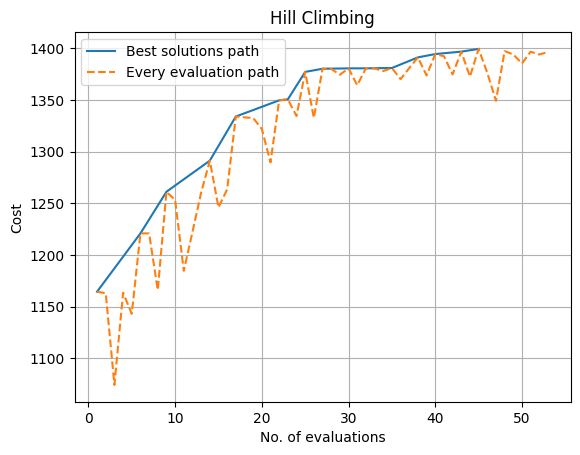

In [32]:
from matplotlib import pyplot as plt

plt.plot(x0, y0, label='Best solutions path')
plt.plot(x0raw, y0raw, '--', label='Every evaluation path')
plt.legend()
plt.xlabel("No. of evaluations")
plt.ylabel("Cost")
plt.title("Hill Climbing")
plt.grid()

Greedy Hill Climbing

In [12]:
# no need to only extract data with flairs

y1 = [float(data['greedy'][i]['Cost']) for i in range(0, len(data['greedy']))]
x1 = [float(data['greedy'][i]['eval']) for i in range(0, len(data['greedy']))]

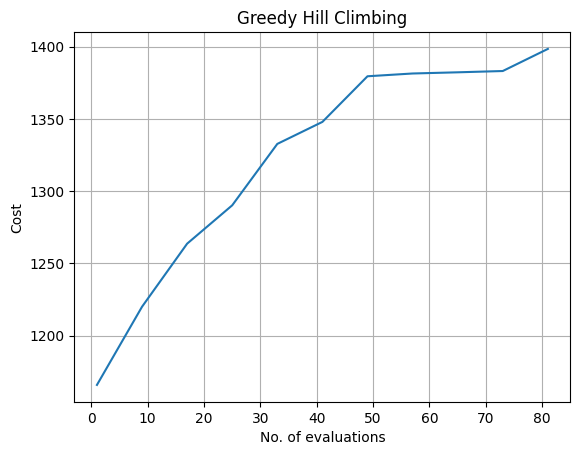

In [16]:
from matplotlib import pyplot as plt

plt.plot(x1,y1)
plt.xlabel("No. of evaluations")
plt.ylabel("Cost")
plt.title("Greedy Hill Climbing")
plt.grid()

Tabu-Greedy Hill Climbing

In [13]:
# no need to only extract data with flairs

y2 = [float(data['greedytabu'][i]['Cost']) for i in range(0, len(data['greedytabu']))]
x2 = [float(data['greedytabu'][i]['eval']) for i in range(0, len(data['greedytabu']))]

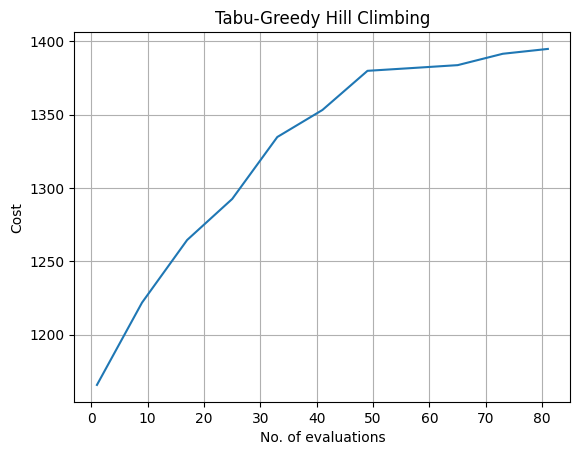

In [19]:
from matplotlib import pyplot as plt

plt.plot(x2,y2)
plt.xlabel("No. of evaluations")
plt.ylabel("Cost")
plt.title("Tabu-Greedy Hill Climbing")
plt.grid()

Simulated Annealing

In [14]:
# extract data with flairs (Initial, New best or Risky choice)
new_data['sa'] = []
for line in data['sa']:
    if 'flair' in line:
       new_data['sa'].append(line)

y3 = [float(new_data['sa'][i]['Cost']) for i in range(0, len(new_data['sa']))]
x3 = [float(new_data['sa'][i]['eval']) for i in range(0, len(new_data['sa']))]

y3raw = [float(data['sa'][i]['Cost']) for i in range(0, len(data['sa']))]
x3raw = [float(data['sa'][i]['eval']) for i in range(0, len(data['sa']))]

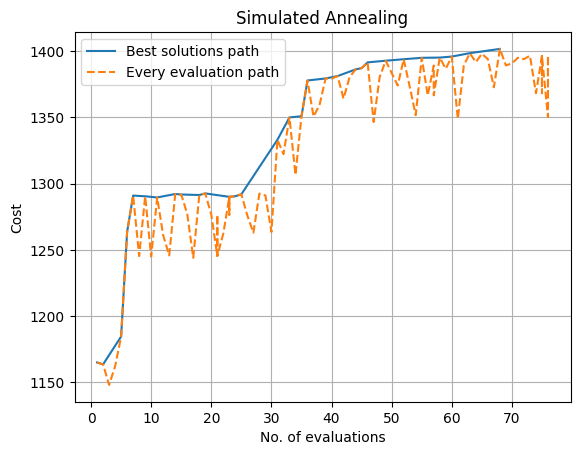

In [29]:
from matplotlib import pyplot as plt

plt.plot(x3, y3, label='Best solutions path')
plt.plot(x3raw, y3raw, '--', label='Every evaluation path')
plt.legend()
plt.xlabel("No. of evaluations")
plt.ylabel("Cost")
plt.title("Simulated Annealing")
plt.grid()

Curious Simulated Annealing (CSA)

In [15]:
# no need to only extract data with flairs

y4raw = [float(data['csa'][i]['Cost']) for i in range(0, len(data['csa']))]
x4raw = [float(data['csa'][i]['eval']) for i in range(0, len(data['csa']))]

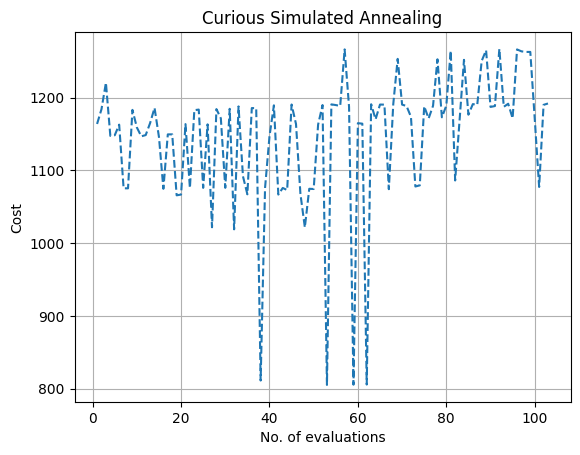

In [35]:
from matplotlib import pyplot as plt

plt.plot(x4raw, y4raw, '--', label='Every evaluation path')
plt.xlabel("No. of evaluations")
plt.ylabel("Cost")
plt.title("Curious Simulated Annealing")
plt.grid()

CMA-ES

In [16]:
# no need to only extract data with flairs

y5raw = [float(data['cmaes'][i]['Cost']) for i in range(0, len(data['cmaes']))]
x5raw = [float(data['cmaes'][i]['eval']) for i in range(0, len(data['cmaes']))]

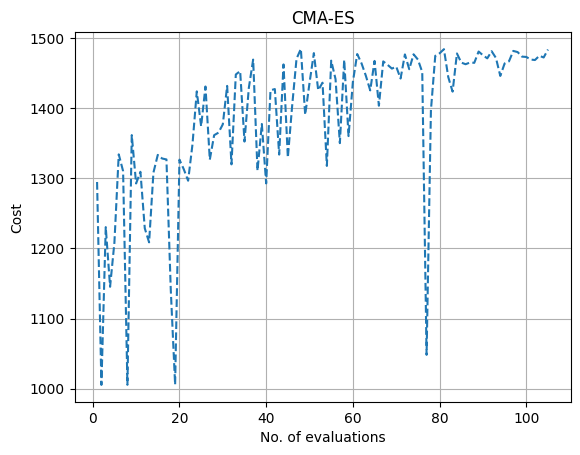

In [9]:
from matplotlib import pyplot as plt

plt.plot(x5raw, y5raw, '--', label='Every evaluation path')
plt.xlabel("No. of evaluations")
plt.ylabel("Cost")
plt.title("CMA-ES")
plt.grid()

### Convergence speed comparison per number of evaluations

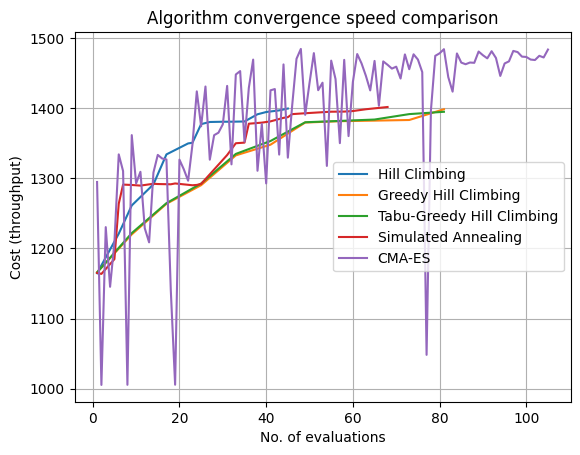

In [17]:
from matplotlib import pyplot as plt

plt.plot(x0, y0, label='Hill Climbing')
plt.plot(x1, y1, label='Greedy Hill Climbing')
plt.plot(x2, y2, label='Tabu-Greedy Hill Climbing')
plt.plot(x3, y3, label='Simulated Annealing')
plt.legend()
plt.xlabel("No. of evaluations")
plt.ylabel("Cost (throughput)")
plt.title("Algorithm convergence speed comparison")
plt.grid()